<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/recurrent_networks/ai_unizar_course_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>.

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
# **Time Series Prediction with Recurrent Neural Networks (RNN)**
---


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Auxiliary functions

In [2]:
def plot_history(history):
    train_loss = history.history['loss']
    epochs = range(1, len(train_loss) + 1)

    # Extract the validation loss values
    val_loss = history.history['val_loss']

    # Plot the training loss and validation loss vs. epoch
    plt.rcParams.update({'font.size': 14})
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    pass


def plot_time_series(x,y_true,model,model_name):
    # Create the plot
    j=np.random.randint(x.shape[0])

    n_steps=x.shape[1]
    print(n_steps)
    time=list(range(1, n_steps + 1))

    pred=model.predict(x[j].reshape(1, n_steps, 1))
    print(pred.shape)
    final_step=pred.shape[1]
    series=x[j]
    true=y_true[j][0:final_step]

    pred=np.squeeze(pred)
    true=np.squeeze(true)

    time_pred=np.arange(n_steps + 1,n_steps + 1+final_step)

    print("MSE=",tf.keras.metrics.mse([true],[pred]).numpy())

    plt.rcParams.update({'font.size': 14})
    plt.plot(time,series,label='data',marker='o',markersize=5)
    plt.plot(time_pred,true,'ro',label='target')
    plt.plot(time_pred,pred,'x',color='black',label=model_name)
    plt.xlabel(r'$t$ (time in a.u.)')
    plt.ylabel(r'$s(t)$')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
    # Show the plot
    plt.show()
    pass

# Generating time series: toy model

$s(t)$ signal as a function of time = two sinusoidal waves + noise
---

$s(t)=\dfrac{1}{2}\sin[(t-\phi_1)(10\omega_1+10)]+\dfrac{1}{5}\sin[(t-\phi_2)(20\omega_2+20)]+noise$

where:
+ $\omega_1, \omega_2, \phi_1, \phi_2 \in [0,1]$
+ $\Delta t=\dfrac{1}{n_{steps}}=\frac{1}{60}$
+ $noise \in [-0.05,0.05]$

In [3]:
def generate_time_series(batch_size, n_steps):
  '''
  Return 4 vectors of random numbers of length batch_size
  '''
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
  return series[..., np.newaxis].astype(np.float32) # data shape for RNN (batch_size,time steps,number of features)

In [4]:
# Generate time series: n_steps for training and n_target as targets
n_steps = 50
n_target = 10
N_series=1000
N_train=700
N_val=200
N_test=100

series = generate_time_series(N_series, n_steps + n_target)
print("Time series shape (batch_size,time steps,number of features)=",series.shape)

X_train, Y_train = series[:N_train, :n_steps], series[:N_train, -n_target:, 0]
X_val, Y_val = series[N_train:N_train+N_val, :n_steps], series[N_train:N_train+N_val, -n_target:, 0]
X_test, Y_test = series[N_series-N_test:, :n_steps], series[N_series-N_test:, -n_target:, 0]

Time series shape (batch_size,time steps,number of features)= (1000, 60, 1)


In [5]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(700, 50, 1) (700, 10)
(200, 50, 1) (200, 10)
(100, 50, 1) (100, 10)


## Plot example

j= 94


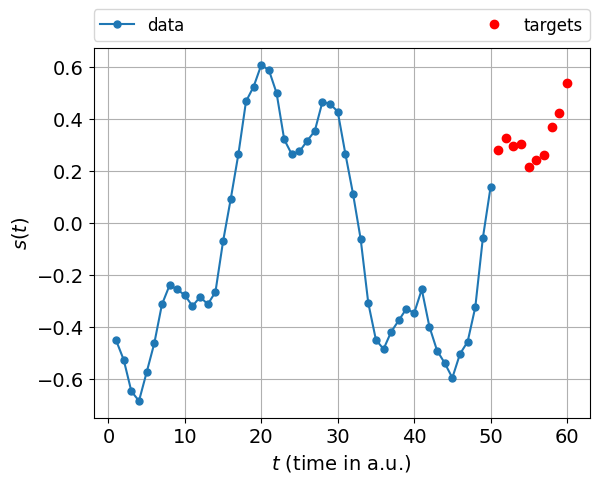

In [6]:
j=np.random.randint(X_test.shape[0])
print('j=',j)
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()

# **Predicting next time step of the time series**

# Baseline (naive prediction): predicting the next time step



In [7]:
#BASELINE1
#we predict the last value from each series
y_pred = X_test[:, -1]
print("y_pred baseline shape=",y_pred.shape)
print('MSE: ')
np.mean(tf.keras.metrics.mse(Y_test,y_pred))

y_pred baseline shape= (100, 1)
MSE: 


0.23428105

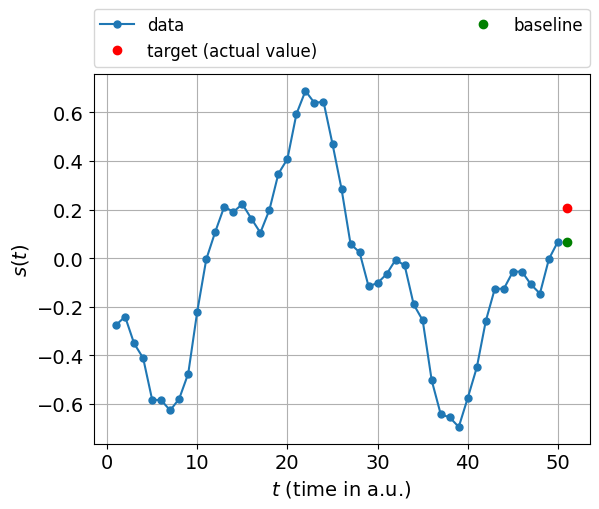

In [8]:
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 2)),Y_train[j,0],'ro',label='target (actual value)')
plt.plot(list(range(n_steps + 1,n_steps + 2)),y_pred[j],'go',label='baseline')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()

# **Single Neuron**

## Dense Neural Network (DNN)

In [ ]:
model1 = tf.keras.models.Sequential([
#tf.keras.layers.Flatten(input_shape=(50, 1)),
tf.keras.layers.Dense(1)
])

model1.summary()
model1.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history1=model1.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))


In [ ]:
ypred=model1.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test, ypred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


0.19866249

In [ ]:
plot_history(history1)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(1, 1)
MSE= 0.0015417513


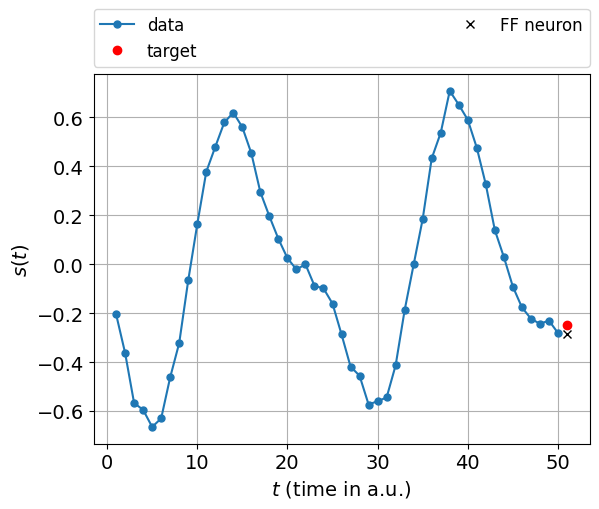

In [ ]:
plot_time_series(X_test,Y_test,model=model1,model_name='FF neuron')

## Recurrent Neural Network (RNN)


Parameters per layer:
+ $W_x=n_{inputs} \times n_{neurons}$
+ $W_y=n_{neurons} \times n_{neurons}$
+ $b= n_{neurons}$

### Simple RNN

In [ ]:
'''
By deafault, it will only return the last output, hyperbolic tangent activation
initial sate is set to 0.

We do not need to specify the length of the
input sequences (unlike with DNN), since a RNNs can
process any number of time steps (this is why we set the first input dimension to None)
'''
model2 = tf.keras.models.Sequential([
#tf.keras.layers.Flatten(input_shape=(50, 1)),        # Compare this line
tf.keras.layers.SimpleRNN(1, input_shape=(None, 1))]) # with this
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history2=model2.fit(X_train, Y_train[:,0],
                    epochs=40,
                    validation_data=(X_val, Y_val[:,0]))

In [ ]:
ypred=model2.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test[:,0], ypred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


0.009196285

In [ ]:
plot_history(history2)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
(1, 1)
MSE= 0.087722406


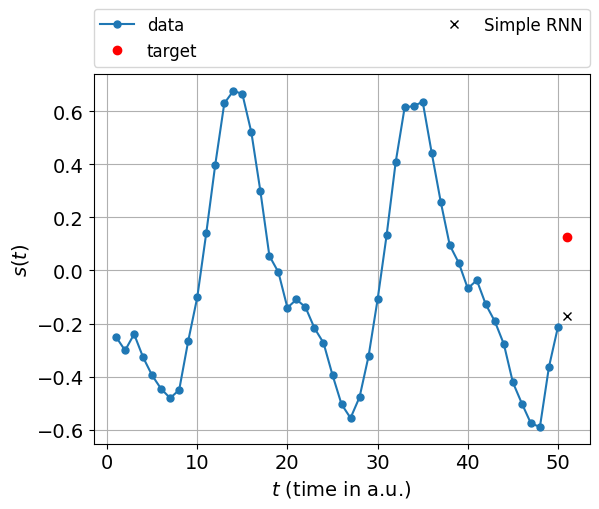

In [ ]:
plot_time_series(X_test,Y_test,model=model2,model_name='Simple RNN')

### Custom Simple RNN code

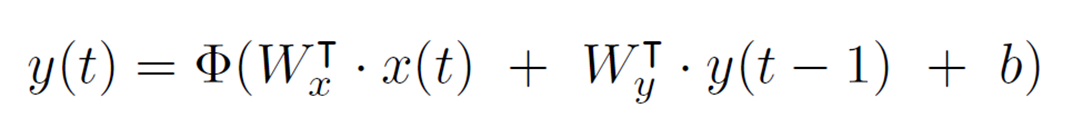

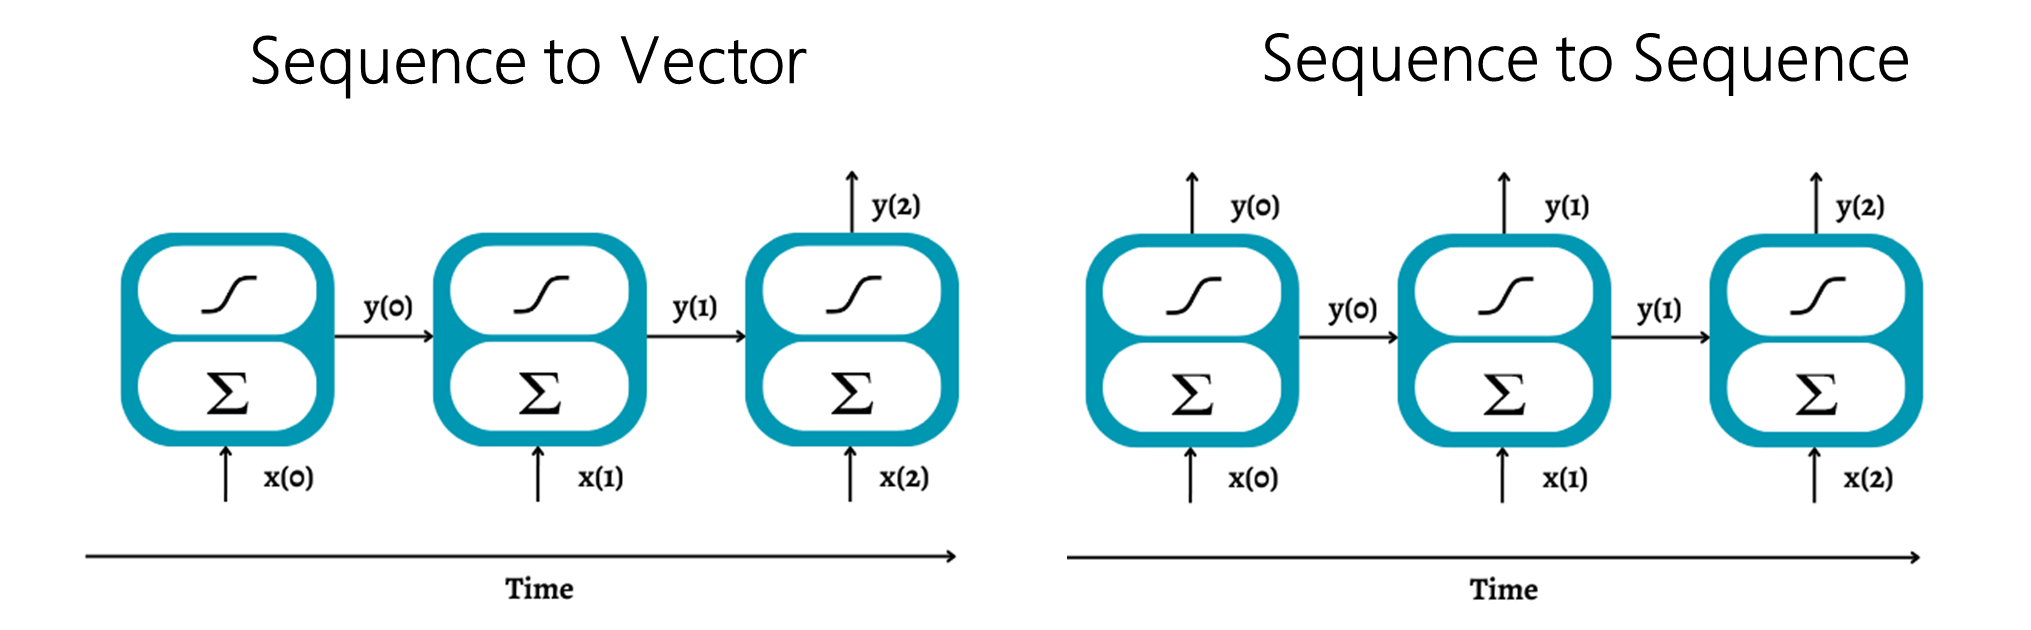

In [ ]:
# Will take the weights from the SimpleRNN model
model2.weights

[<KerasVariable shape=(1, 1), dtype=float32, path=sequential_1/simple_rnn/simple_rnn_cell/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=sequential_1/simple_rnn/simple_rnn_cell/recurrent_kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=sequential_1/simple_rnn/simple_rnn_cell/bias>]

x(t) shape: (50, 1)
W,U,b shapes: (1, 1) (1, 1) (1,)
successive output length= 50
(50, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Custom SimpleRNN prediction shape= (50, 1)
Keras SimpleRNN shape= (1,)


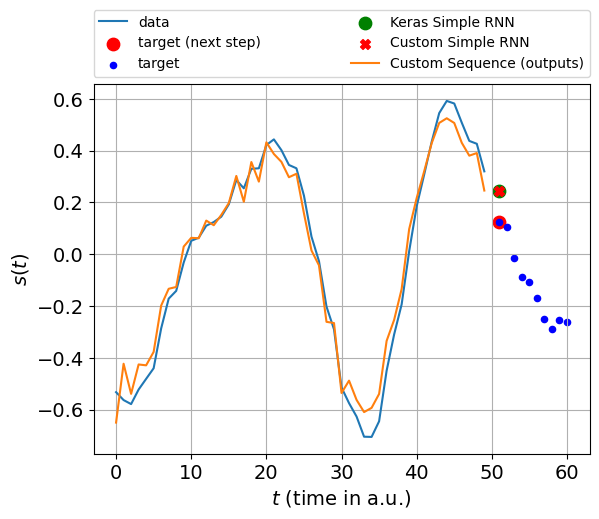

In [ ]:
import numpy as np
# Take a random series from X_test
j=np.random.randint(X_test.shape[0])
inputs =X_test[j]
print("x(t) shape:",inputs.shape)

# Input_features and output_feauteres of the RNN cell
input_features = 1
output_features = 1

# Weights and bias
model=model2
W=model.weights[0].numpy() # Regular kernel
U=model.weights[1].numpy() # Recurrent Kernel
b=model.weights[2].numpy() # bias
print("W,U,b shapes:",W.shape,U.shape,b.shape)

# List to add the successive outputs (sequence)
sequence = []

# Initial state of the RNN cell
y_tless1 = np.zeros((output_features,))

# Recurrent loop: for every time step (= len sequence) it produces output=y_t
# that is appended into a list
# The state y_t is updated in each iteration
for x_t in inputs:
  y_t = np.tanh(np.dot(W, x_t) + np.dot(U, y_tless1) + b)
  sequence.append(y_t)
  y_tless1 = y_t

# Get the final output sequence
print("successive output length=",len(sequence))
final_output_sequence = np.array(sequence)

# Predictions
pred_naive=final_output_sequence
print(pred_naive.shape)
pred_keras_SimpleRNN=model.predict(X_test)[j]
print("Custom SimpleRNN prediction shape=",pred_naive.shape)
print("Keras SimpleRNN shape=",pred_keras_SimpleRNN.shape)

# Plot
plt.plot(inputs,label='data')
plt.scatter(51,Y_test[j,0],label='target (next step)',color='red',marker='o',s=80)
plt.scatter(np.arange(51,61),Y_test[j,:],label='target',color='blue',marker='o',s=20)
plt.scatter(51,pred_keras_SimpleRNN,label='Keras Simple RNN',color='green',marker='o',s=80)
plt.scatter(51,pred_naive[-1],label='Custom Simple RNN',color='red',marker='X',s=50)
plt.plot(pred_naive,label='Custom Sequence (outputs)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=10)
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.show()

### LSTM

In [ ]:
'''
By deafault, it will only return the last output, hyperbolic tangent activation
initial sate is set to 0

We do not need to specify the length of the
input sequences (unlike in the previous model), since a recurrent neural network can
process any number of time steps (this is why we set the first input dimension to None)
'''
model3 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(1, input_shape=(None, 1))])

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history3=model3.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
ypred=model3.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test, ypred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


0.20453274

In [ ]:
plot_history(history3)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
(1, 1)
MSE= 0.12559503


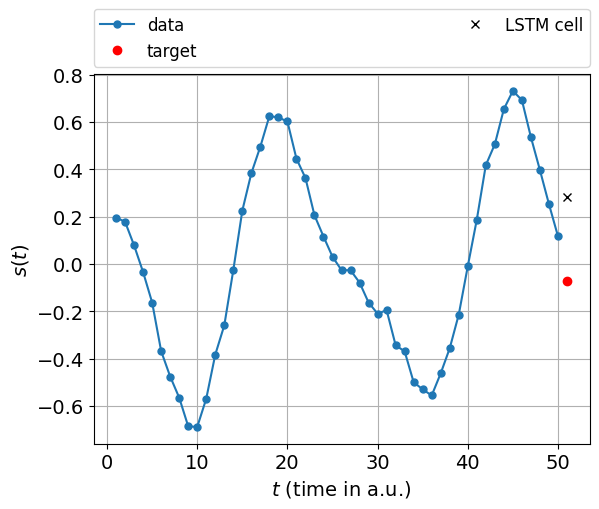

In [ ]:
plot_time_series(X_test,Y_test,model=model3,model_name='LSTM cell')

### GRU

In [ ]:
model4 = tf.keras.models.Sequential([
tf.keras.layers.GRU(1, input_shape=(None, 1))])

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history4=model4.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
ypred=model4.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test, ypred))

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


0.17363887

In [ ]:
plot_history(history4)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(1, 1)
MSE= 0.1454718


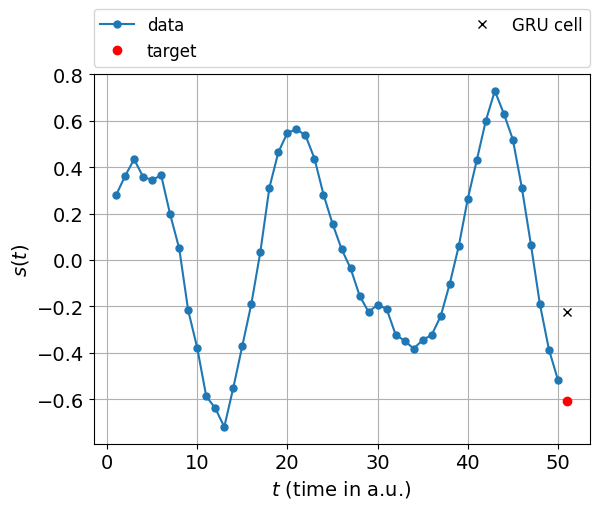

In [ ]:
plot_time_series(X_test,Y_test,model=model4,model_name='GRU cell')

# **Deep Neural Networks**

### Dense Neural Network (DNN)

In [10]:
model5 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=(50, 1)),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(1)
])

model5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,461 (5.71 KB)

 Trainable params: 1,461 (5.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model5.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history5=model5.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [12]:
ypred=model5.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test, ypred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


0.18628931

In [ ]:
plot_history(history5)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
(1, 1)
MSE= 0.0006982005


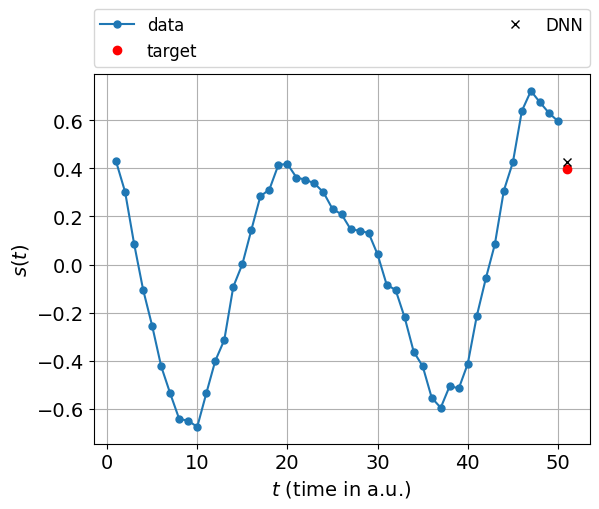

In [14]:
plot_time_series(X_test,Y_test,model=model5,model_name='DNN')

## Recurrent Neural Networks (RNN)

###Simple RNN

In [15]:
'''
Set return_sequences=True for all recurrent layers except the last one
It returns the entire sequence of outputs for each sample (one vector per timestep per sample).
The shape of this output is (batch_size, timesteps, units='neurons')
'''
model6 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.SimpleRNN(20, return_sequences=True),
tf.keras.layers.SimpleRNN(1)
])

model6.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, None, 20)            │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 20)            │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 1)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

Parameters per layer:
+ $W_x=n_{inputs} \times n_{neurons}$
+ $W_y=n_{neurons} \times n_{neurons}$
+ $b= n_{neurons}$

In [19]:
for w in model6.weights:
  print(w)

for layer in model6.layers:
  print("\n",layer.name)
  print("Layer input shape=",layer.input.shape)
  print("Layer output shape=",layer.output.shape)

<KerasVariable shape=(1, 20), dtype=float32, path=sequential_2/simple_rnn/simple_rnn_cell/kernel>
<KerasVariable shape=(20, 20), dtype=float32, path=sequential_2/simple_rnn/simple_rnn_cell/recurrent_kernel>
<KerasVariable shape=(20,), dtype=float32, path=sequential_2/simple_rnn/simple_rnn_cell/bias>
<KerasVariable shape=(20, 20), dtype=float32, path=sequential_2/simple_rnn_1/simple_rnn_cell/kernel>
<KerasVariable shape=(20, 20), dtype=float32, path=sequential_2/simple_rnn_1/simple_rnn_cell/recurrent_kernel>
<KerasVariable shape=(20,), dtype=float32, path=sequential_2/simple_rnn_1/simple_rnn_cell/bias>
<KerasVariable shape=(20, 1), dtype=float32, path=sequential_2/simple_rnn_2/simple_rnn_cell/kernel>
<KerasVariable shape=(1, 1), dtype=float32, path=sequential_2/simple_rnn_2/simple_rnn_cell/recurrent_kernel>
<KerasVariable shape=(1,), dtype=float32, path=sequential_2/simple_rnn_2/simple_rnn_cell/bias>

 simple_rnn
Layer input shape= (None, None, 1)
Layer output shape= (None, None, 20)

 

In [ ]:
model6.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history6=model6.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [21]:
ypred=model6.predict(X_test)
np.mean(tf.keras.metrics.mse(Y_test, ypred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


0.18927594

In [ ]:
plot_history(history6)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(1, 1)
MSE= 0.0019951027


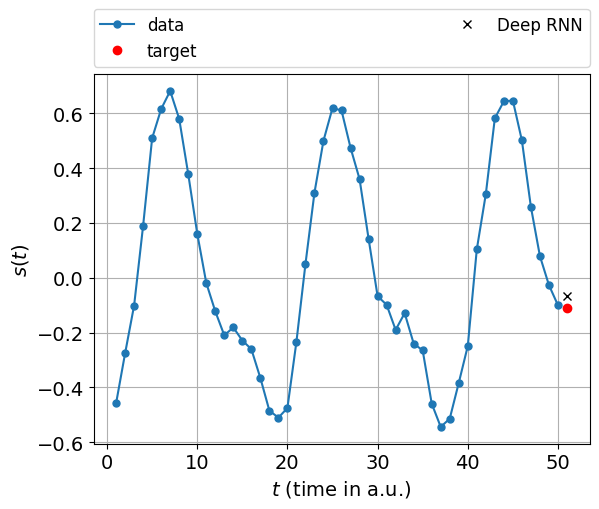

In [27]:
plot_time_series(X_test,Y_test,model=model6,model_name='Deep RNN')

In [ ]:
model7 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.SimpleRNN(20),
tf.keras.layers.Dense(1)
])

model7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, None, 20)            │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history7=model7.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
plot_history(history7)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
(1, 1)
MSE= 0.0011331538


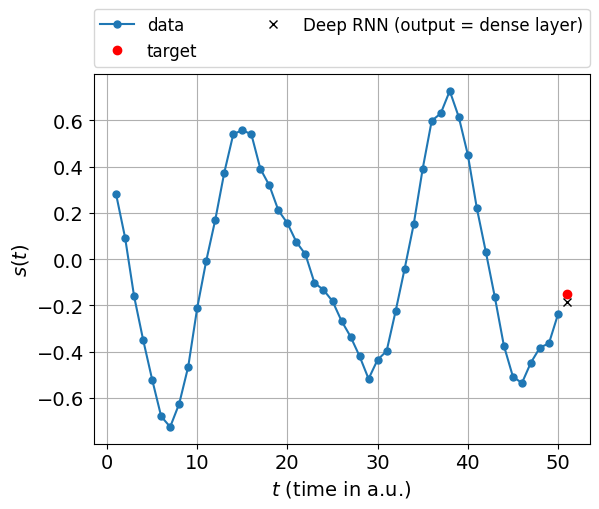

In [ ]:
plot_time_series(X_test,Y_test,model=model7,model_name='Deep RNN (output = dense layer)')

### LSTM

In [30]:
model8 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(1)
])

model8.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 20)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model8.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history8=model8.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
plot_history(history8)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
(1, 1)
MSE= 0.001339132


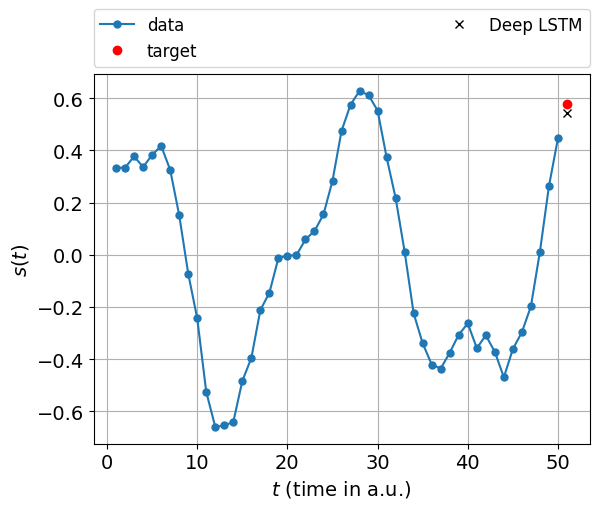

In [33]:
plot_time_series(X_test,Y_test,model=model8,model_name='Deep LSTM')



### GRU

In [ ]:
model9 = tf.keras.models.Sequential([
tf.keras.layers.GRU(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.GRU(20),
tf.keras.layers.Dense(1)
])

model9.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, None, 20)            │           1,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 20)                  │           2,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,921 (15.32 KB)

 Trainable params: 3,921 (15.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model9.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history9=model9.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
plot_history(history9)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
(1, 1)
MSE= 0.0029326663


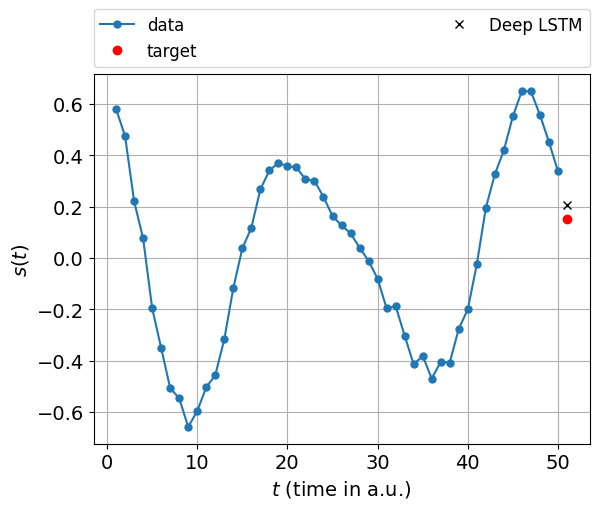

In [ ]:
plot_time_series(X_test,Y_test,model=model9,model_name='Deep LSTM')

# **Forecasting several time steps from a pre-trained RNN**

Options:
1.   **Iterative method**: Forecast the next step, add it to the time series, and repeat
2.   **Sequence to vector**: predict the last timesteps (targets).
3.   **Sequence to sequence**: give all steps at once.

## Forecasting the next step iteratively


In [34]:
model= model8 #Choose one of the already trained models

In [35]:
# Prediction
j = np.random.randint(0, len(Y_test))

sequence=X_test[j].reshape(1,X_train.shape[1], 1)
print("Sequence shape=",sequence.shape)

for i in range (0,n_target):
  pred=model.predict(sequence[:,i:,:],verbose=0) #predict next timestep with previous steps
  sequence=np.concatenate((sequence, pred.reshape(1, 1, 1)), axis=1) #add it to the sequence
  print("Sequence shape=",sequence.shape)
prediction=np.squeeze(sequence[0,n_steps:,:])

print("\nPrediction=\n",prediction)

Sequence shape= (1, 50, 1)
Sequence shape= (1, 51, 1)
Sequence shape= (1, 52, 1)
Sequence shape= (1, 53, 1)
Sequence shape= (1, 54, 1)
Sequence shape= (1, 55, 1)
Sequence shape= (1, 56, 1)
Sequence shape= (1, 57, 1)
Sequence shape= (1, 58, 1)
Sequence shape= (1, 59, 1)
Sequence shape= (1, 60, 1)

Prediction=
 [-0.32440543 -0.14924717  0.00753546  0.13929543  0.24133164  0.3132749
  0.35734338  0.3776256   0.37888205  0.3664075 ]


MSE= 0.03415235


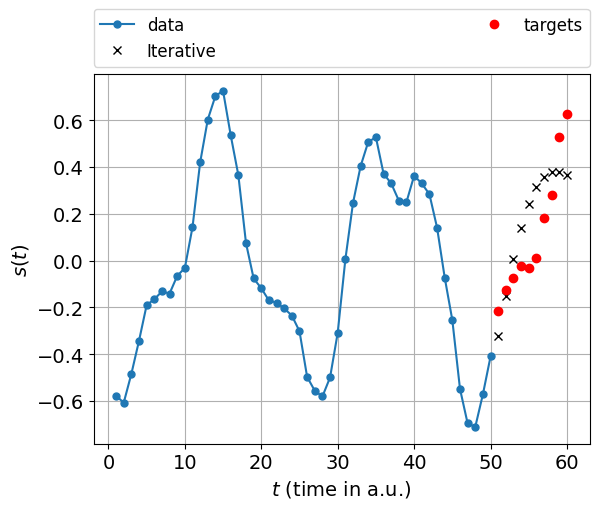

In [36]:
print("MSE=",tf.keras.metrics.mse(prediction,Y_test[j]).numpy())

# Plot
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 11)),prediction,'x',color='black',label='Iterative')
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
plt.show()

## LSTM Sequence-to-Vector

In [ ]:
model10 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(10) # Compare to model 8
])
model10.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, None, 20)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,250 (20.51 KB)

 Trainable params: 5,250 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model10.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history10=model10.fit(X_train, Y_train, epochs=40, validation_data=(X_val, Y_val))

In [ ]:
plot_history(history10)

50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
(1, 10)
MSE= [0.0143325]


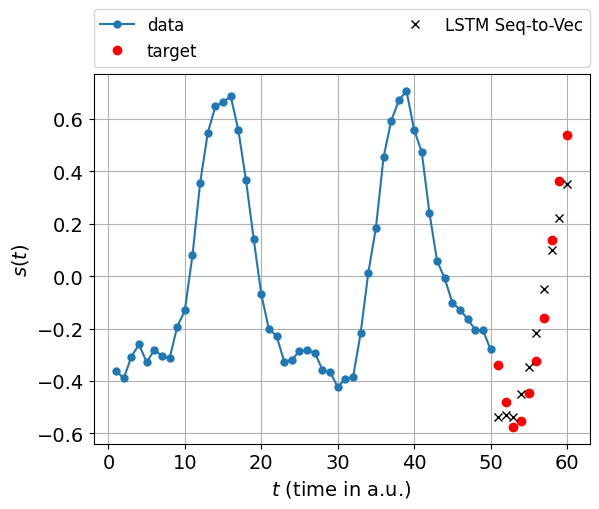

In [ ]:
plot_time_series(X_test,Y_test,model=model10,model_name='LSTM Seq-to-Vec')

##LSTM Sequence-to-Sequence

### Generating data

In [45]:
# Every target will contain n_steps vectors of dimension 10, each one shifted by 10 steps.
n_steps = 50
n_target=10

Y = np.empty((N_series, n_steps, n_target)) # each target is a sequence of 10D vectors

for step_ahead in range(1, n_target + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]

Y_train_s2s = Y[:N_train]
Y_val_s2s = Y[N_train:N_train+N_val]
Y_test_s2s = Y[N_train+N_val:]

x_train shape= (700, 50, 1)
y_train shape= (700, 50, 10)


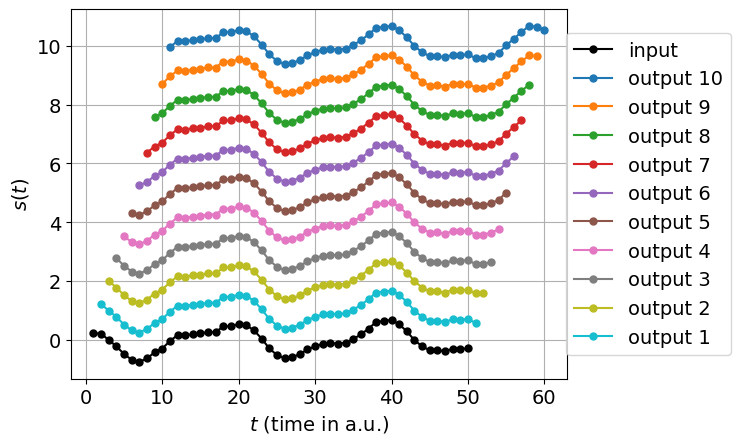

In [46]:
print("x_train shape=",X_train.shape)
print("y_train shape=",Y_train_s2s.shape)

j=np.random.randint(X_test.shape[0])

# Plot
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],color='black',label='input',markersize=5,marker='o')
for step_ahead in range(n_target ,0,-1):
  plt.plot(list(range(1+step_ahead, step_ahead+n_steps+1)),Y_test_s2s[j,:,step_ahead-1]+step_ahead,markersize=5,marker='o',label="output "+str(step_ahead))
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
plt.grid(True)
plt.show()

### The LSTM network


In [41]:
model11 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20, return_sequences=True),
tf.keras.layers.Dense(10)
])

model11.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, None, 20)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 20)            │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, None, 10)            │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,250 (20.51 KB)

 Trainable params: 5,250 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
for w in model11.weights:
  print(w)


<KerasVariable shape=(1, 80), dtype=float32, path=sequential_4/lstm_2/lstm_cell/kernel>
<KerasVariable shape=(20, 80), dtype=float32, path=sequential_4/lstm_2/lstm_cell/recurrent_kernel>
<KerasVariable shape=(80,), dtype=float32, path=sequential_4/lstm_2/lstm_cell/bias>
<KerasVariable shape=(20, 80), dtype=float32, path=sequential_4/lstm_3/lstm_cell/kernel>
<KerasVariable shape=(20, 80), dtype=float32, path=sequential_4/lstm_3/lstm_cell/recurrent_kernel>
<KerasVariable shape=(80,), dtype=float32, path=sequential_4/lstm_3/lstm_cell/bias>
<KerasVariable shape=(20, 10), dtype=float32, path=sequential_4/dense_5/kernel>
<KerasVariable shape=(10,), dtype=float32, path=sequential_4/dense_5/bias>


In [48]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model11.compile(loss="mse", optimizer=optimizer, metrics=['mae'])

In [ ]:
history11=model11.fit(X_train, Y_train_s2s, epochs=40, validation_data=(X_val, Y_val_s2s))

In [ ]:
plot_history(history11)

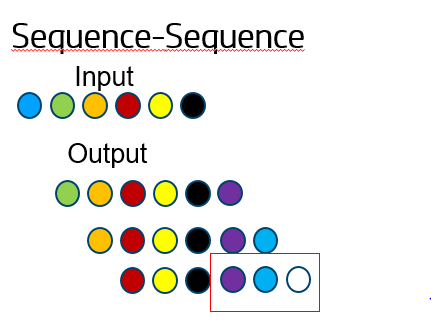

Y_test shape= (100, 50, 10)
Prediction shape= (1, 50, 10)

MSE= 0.0036590231673601934


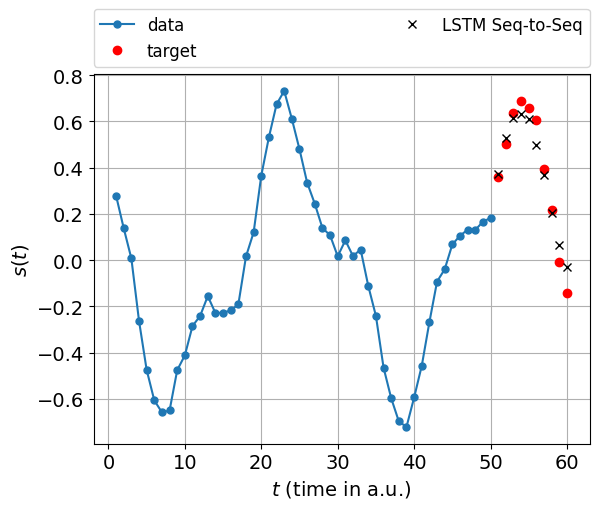

In [52]:
# Y_test_s2s = (batch_size,time_steps,target_points)
# Note that Y_test_s2s[j,:,i] is the data (X_test) shifted i+1 steps ahead
# Y_test_s2s[j,-1,:] = Y_test_s2s[j,-1] = Y_test_s2s[j][-1]
# are the last target_points values of all the shifted functions

n_target=10
j=np.random.randint(X_test.shape[0])
pred=model11.predict(X_test[j].reshape(1, 50, 1),verbose=0)
print("Y_test shape=",Y_test_s2s.shape)
print("Prediction shape=",pred.shape)

print("\nMSE=",tf.keras.metrics.mse(pred[0][-1],Y_test_s2s[j][-1]).numpy())

# Plot
plt.rcParams.update({'font.size': 14})
plt.plot(np.arange(1, n_steps + 1),X_test[j],label='data',marker='o',markersize=5)
plt.plot(np.arange(n_steps + 1,n_steps + n_target+1),Y_test_s2s[j][-1],'ro',label='target')
plt.plot(np.arange(n_steps + 1,n_steps + n_target+1),pred[0][-1],'x',color='black',label='LSTM Seq-to-Seq')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
plt.show()
